<IPython.core.display.Javascript object>


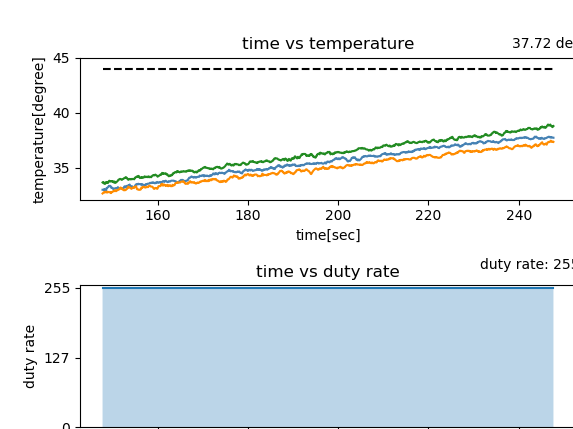

In [ ]:
%matplotlib notebook

import os
import sys
import inspect
from time import sleep

import numpy as np
import matplotlib.pyplot as plt

# add root path to access project modules
HERE_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append(HERE_PATH)

# add the path of commanduino
CDUINO_PATH = os.path.join(HERE_PATH, '../library/commanduino')
sys.path.append(CDUINO_PATH)

# add the path of the wastebot package
WASTEBOT_PATH= os.path.join(HERE_PATH, '../library/wastebot')
sys.path.append(WASTEBOT_PATH)

# Preparing for CommandManager to communicate with Arduino
from commanduino import CommandManager
cmdMng = CommandManager.from_configfile('./heatbed_control_arduino.json')

# Set the sampling frequency and sampling interval
sampling_freq = 10.0 # unit: Hz
sampling_intvl = 1.0 / sampling_freq # unit: sec

# constructing the thermistor processors
num_moving_average = 10 # Number of elements of moving average
num_therm = 3; # Number of thermistors
initial_values = np.zeros((num_moving_average, num_therm))
for i in xrange(num_moving_average):
    initial_values[i, 0] = float(cmdMng.read_thermistor0.get_level())
    initial_values[i, 1] = float(cmdMng.read_thermistor1.get_level())
    initial_values[i, 2] = float(cmdMng.read_thermistor2.get_level())
    sleep(sampling_intvl)

rt = 100000.0 # The resistance of the thermistor at 25°C (unit: ohm). 

# load parameters of "Steinhart–Hart" equation for the thermistor.
import json
with open('./B57560G11104.json') as f:
    sh_params = json.load(f)

rd = 4700.0   # The resistance of the resistor in the voltage divider (unit: ohm).
from wastebot.heatbed import ThermProc
tp0 = ThermProc(initial_values[:, 0], rt, sh_params, rd, 0.5)
tp1 = ThermProc(initial_values[:, 1], rt, sh_params, rd, 2.0)
tp2 = ThermProc(initial_values[:, 2], rt, sh_params, rd, 1.6)

# Heatbed control section
from wastebot.heatbed import Controller

# Setting of the controller parameter
# sv (Set variable) = target temperature, unit: celsius degree
# pv_range (Process variable range) = temperature range, unit: celsius degree
# mv_max (Max manipulative variable) = max duty rate (0.0 ~ 255.0, integer)
# prop_band (Proportional band), unit: %
# integral_time (Integral time), unit: sec
# derivative_time (Derivative_time), unit: sec
# initial_pv (initial process variable) = initial temperature, unit: celsius degree
controller_input = {"sv":44.0,
                                  "pv_range":np.array([10.0, 50.0]),
                                  "mv_max": 255.0,
                                  "prop_band":10.0,
                                  "integral_time":1500.0,
                                  "derivative_time":0.0007,
                                  "initial_pv": tp0.temperature}

# constructing the controller
con0 = Controller(controller_input)

# initialize matplotlib plot
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlabel("time[sec]")
ax1.set_ylabel("temperature[degree]")
ax1.set_title("time vs temperature")
ax1_pos = ax1.get_position()
txt1 = fig.text(ax1_pos.x1 - 0.1, ax1_pos.y1 + 0.02, "")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel("time[sec]")
ax2.set_ylabel("duty rate")
ax2.set_title("time vs duty rate")
ax2_pos = ax2.get_position()
txt2 = fig.text(ax2_pos.x1 - 0.15, ax2_pos.y1 - 0.02, "")

# interactive mode
plt.ion()

# adjust subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)
fig.show()
fig.canvas.draw()

number_of_viz_points = 1000
time_buffer = np.arange(number_of_viz_points, dtype=float) / sampling_freq
tmp_buffer = np.zeros((number_of_viz_points, num_therm), dtype=float)
duty_buffer = np.zeros(number_of_viz_points, dtype=int)
loop_counter = 0L


# main loop
try:
    while True:
        # read temperature from thermistors
        tp0.read_adc_output(float(cmdMng.read_thermistor0.get_level()))
        tp1.read_adc_output(float(cmdMng.read_thermistor1.get_level()))
        tp2.read_adc_output(float(cmdMng.read_thermistor2.get_level()))
        
        # set process variable of controler
        con0.pv = tp0.temperature # Now,  we use only tp0's value
        
        # set the heatbed power(duty rate)
        cmdMng.write_heatbed0.set_pwm_value(int(np.around(con0.mv)))
        
        # visualize
        if loop_counter < number_of_viz_points:
            tmp_buffer[loop_counter, 0] = tp0.temperature
            tmp_buffer[loop_counter, 1] = tp1.temperature
            tmp_buffer[loop_counter, 2] = tp2.temperature
            
            ax1.clear()
            ax1.plot(time_buffer[0:loop_counter], tmp_buffer[0:loop_counter, 0], color='steelblue')
            ax1.plot(time_buffer[0:loop_counter], tmp_buffer[0:loop_counter, 1], color='darkorange')
            ax1.plot(time_buffer[0:loop_counter], tmp_buffer[0:loop_counter, 2], color='forestgreen')
            txt1.set_text(format(tmp_buffer[loop_counter, 0], ".2f")+ " deg")
            
            duty_buffer[loop_counter] = int(np.around(con0.mv))
            ax2.clear()
            ax2.plot(time_buffer[0:loop_counter], duty_buffer[0:loop_counter])
            ax2.fill_between(time_buffer[0:loop_counter], duty_buffer[0:loop_counter],  alpha = 0.3)
            txt2.set_text("duty rate: " + str(duty_buffer[loop_counter]))
        else:
            tmp_buffer = np.roll(tmp_buffer, shift=-1, axis=0)
            tmp_buffer[-1, 0] = tp0.temperature
            tmp_buffer[-1, 1] = tp1.temperature
            tmp_buffer[-1, 2] = tp2.temperature
            time_buffer = np.roll(time_buffer, -1)
            time_buffer[-1] = float(loop_counter) / sampling_freq
            ax1.clear()
            ax1.plot(time_buffer, tmp_buffer[:, 0], color='steelblue')
            ax1.plot(time_buffer, tmp_buffer[:, 1], color='darkorange')
            ax1.plot(time_buffer, tmp_buffer[:, 2], color='forestgreen')
            txt1.set_text(format(tmp_buffer[-1, 0], ".2f") + " deg")
            
            duty_buffer = np.roll(duty_buffer, -1)
            duty_buffer[-1] = int(np.around(con0.mv))
            ax2.clear()
            ax2.plot(time_buffer, duty_buffer)
            ax2.fill_between(time_buffer, duty_buffer, alpha = 0.3)
            txt2.set_text("duty rate: " + str(duty_buffer[-1]))
        
        ax1.hlines(controller_input['sv'], time_buffer[0], time_buffer[-1], linestyles="dashed")
        c_ymin, c_ymax = ax1.get_ylim()
        if (c_ymax < (controller_input['sv'] +1.0)) and (c_ymax - c_ymin >= 1.5):
            ax1.set_ylim([c_ymin, controller_input['sv'] + 1])
        ax1.set_xlabel("time[sec]")
        ax1.set_ylabel("temperature[degree]")
        ax1.set_title("time vs temperature")
        
        c_xmin, c_xmax = ax1.get_xlim()
        ax2.set_xlim([c_xmin, c_xmax])
        ax2.set_ylim([0, 260])
        ax2.set_yticks([0, 127, 255])
        ax2.set_xlabel("time[sec]")
        ax2.set_ylabel("duty rate")
        ax2.set_title("time vs duty rate")
        
        fig.canvas.draw()
    
        sleep(sampling_intvl)
        loop_counter = loop_counter + 1
except BaseException: 
    # Power off command of the heatbed 
    cmdMng.write_heatbed0.set_pwm_value(0)
    raise

In [2]:
# Emergency power off command of the heatbed 
try:
    cmdMng.write_heatbed0.set_pwm_value(0)
except NameError:
    from commanduino import CommandManager
    cmdMng = CommandManager.from_configfile('./heatbed_controller.json')
    cmdMng.write_heatbed0.set_pwm_value(0)
